# Deepfake Audio Detection - Complete Pipeline

This notebook contains the entire pipeline for detecting deepfake audio, merged into a single file for easier execution.

**Sections:**
1.  **Setup & Imports**: Libraries and configuration.
2.  **Preprocessing**: Audio loading, noise reduction, and Mel Spectrogram extraction.
3.  **Data Loading**: Scanning the dataset and handling class imbalance.
4.  **Model Architecture**: CNN-BiLSTM model definition.
5.  **Training**: Training the model with class weights and callbacks.
6.  **Evaluation**: Visualizing performance metrics and confusion matrix.

In [1]:
# --- 1. Setup & Imports ---
import os
import ctypes
import sys

# Define paths for CUDA 11.0 (Now compatible with TensorFlow 2.8)
cuda_11_path = r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.0\bin"
project_path = os.getcwd()

# 1. Update PATH environment variable
os.environ['PATH'] = cuda_11_path + os.pathsep + project_path + os.pathsep + os.environ['PATH']

# 2. Add DLL directories
try:
    os.add_dll_directory(cuda_11_path)
    print(f"Added DLL directory: {cuda_11_path}")
except Exception as e:
    print(f"Failed to add DLL directory: {e}")

try:
    os.add_dll_directory(project_path)
    print(f"Added DLL directory: {project_path}")
except Exception as e:
    print(f"Failed to add DLL directory: {e}")

# 3. Pre-load DLLs
def load_dll(path):
    if os.path.exists(path):
        try:
            ctypes.CDLL(path)
            print(f"Successfully loaded {os.path.basename(path)}")
        except Exception as e:
            print(f"Failed to load {os.path.basename(path)}: {e}")
    else:
        print(f"Warning: {path} not found.")

cudart_path = os.path.join(cuda_11_path, "cudart64_110.dll")
load_dll(cudart_path)

cudnn_path = os.path.join(cuda_11_path, "cudnn64_8.dll")
load_dll(cudnn_path)

zlibwapi_path = os.path.join(cuda_11_path, "zlibwapi.dll")
load_dll(zlibwapi_path)

import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import noisereduce as nr
import IPython.display as ipd
import soundfile as sf
from datetime import datetime

# Check GPU
print(f"TensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(gpus)}")
if gpus:
    for gpu in gpus:
        print(f"  - {gpu.name}: {gpu.device_type}")
else:
    print("WARNING: No GPU detected.")


Failed to add DLL directory: [WinError 3] The system cannot find the path specified: 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.0\\bin'
Added DLL directory: c:\DeepfakeProject


c:\DeepfakeProject\venv_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TensorFlow Version: 2.10.0
Num GPUs Available: 1
  - /physical_device:GPU:0: GPU


In [2]:
# --- HELPER FUNCTIONS ---
import librosa
import numpy as np
import noisereduce as nr
import matplotlib.pyplot as plt
import IPython.display as ipd
import os

def load_audio(file_path, duration=5, sr=16000, apply_noise_reduction=False):
    try:
        y, _ = librosa.load(file_path, sr=sr, duration=duration)
        if apply_noise_reduction:
            y = nr.reduce_noise(y=y, sr=sr)
        target_length = int(duration * sr)
        if len(y) < target_length:
            y = np.pad(y, (0, target_length - len(y)), mode='constant')
        else:
            y = y[:target_length]
        return y
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def visualize_audio_sample(file_path, title="Audio Sample", sr=16000):
    try:
        y = load_audio(file_path, sr=sr)
        if y is None: return
        fig, axes = plt.subplots(2, 1, figsize=(12, 8))
        axes[0].plot(y, color='cyan', alpha=0.7)
        axes[0].set_title(f'{title} - Waveform')
        axes[0].grid(True, alpha=0.3)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        img = librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[1], cmap='viridis')
        axes[1].set_title(f'{title} - Mel Spectrogram')
        fig.colorbar(img, ax=axes[1], format='%+2.0f dB')
        plt.tight_layout()
        plt.show()
        print(f"Playing: {os.path.basename(file_path)}")
        display(ipd.Audio(y, rate=sr))
    except Exception as e:
        print(f"Error: {e}")

# Augmentations
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Gain, Shift
augment_pipeline = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5), 
    TimeStretch(min_rate=0.9, max_rate=1.1, p=0.5), 
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5), 
    Shift(min_shift=-0.2, max_shift=0.2, p=0.5),
    Gain(min_gain_db=-6, max_gain_db=6, p=0.5),
])

def apply_augmentation(y, sr=16000):
    try:
        if y.dtype != np.float32: y = y.astype(np.float32)
        return augment_pipeline(samples=y, sample_rate=sr)
    except Exception: return y


In [3]:

import librosa
import numpy as np
import noisereduce as nr
import matplotlib.pyplot as plt
import IPython.display as ipd
import os

def load_audio(file_path, duration=5, sr=16000, apply_noise_reduction=False):
    try:
        y, _ = librosa.load(file_path, sr=sr, duration=duration)
        if apply_noise_reduction:
            y = nr.reduce_noise(y=y, sr=sr)
        target_length = int(duration * sr)
        if len(y) < target_length:
            y = np.pad(y, (0, target_length - len(y)), mode='constant')
        else:
            y = y[:target_length]
        return y
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def visualize_audio_sample(file_path, title="Audio Sample", sr=16000):
    try:
        y = load_audio(file_path, sr=sr)
        if y is None: return
        fig, axes = plt.subplots(2, 1, figsize=(12, 8))
        axes[0].plot(y, color='cyan', alpha=0.7)
        axes[0].set_title(f'{title} - Waveform')
        axes[0].grid(True, alpha=0.3)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        img = librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[1], cmap='viridis')
        axes[1].set_title(f'{title} - Mel Spectrogram')
        fig.colorbar(img, ax=axes[1], format='%+2.0f dB')
        plt.tight_layout()
        plt.show()
        print(f"Playing: {os.path.basename(file_path)}")
        display(ipd.Audio(y, rate=sr))
    except Exception as e:
        print(f"Error: {e}")


Scanning Training Data...
Training Samples: 36506 (Real: 13706, Fake: 22800)

Visualizing a random sample:


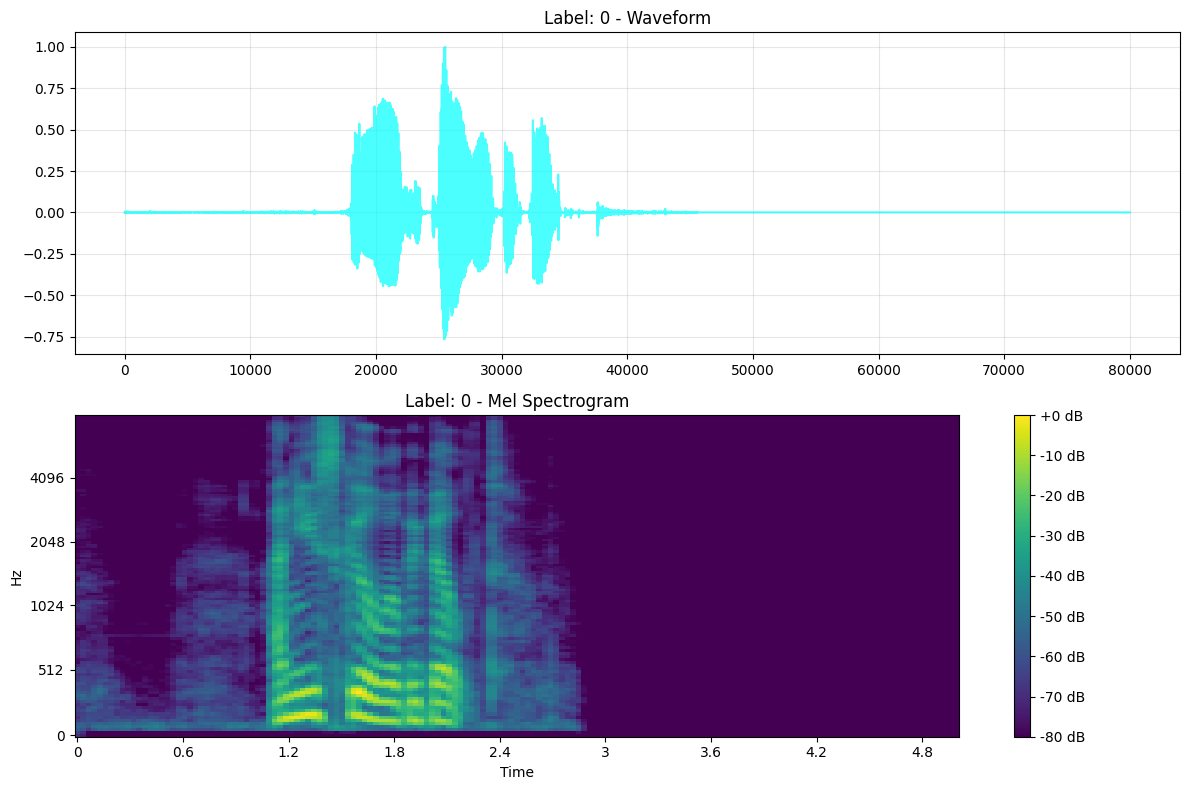

Playing: LA_T_1000406.flac


Class Weights: {0: 1.3317525171457756, 1: 0.8005701754385965}


In [4]:

# --- Data Scanning ---
def scan_dataset(data_dir):
    files = []
    labels = []
    real_dir = os.path.join(data_dir, 'real')
    fake_dir = os.path.join(data_dir, 'fake')
    
    if os.path.exists(real_dir):
        for f in os.listdir(real_dir):
            if f.lower().endswith(('.wav', '.mp3', '.flac')):
                files.append(os.path.join(real_dir, f))
                labels.append(0)
    if os.path.exists(fake_dir):
        for f in os.listdir(fake_dir):
            if f.lower().endswith(('.wav', '.mp3', '.flac')):
                files.append(os.path.join(fake_dir, f))
                labels.append(1)
    return files, labels

TRAIN_DIR = 'data/dataset/train'
print("Scanning Training Data...")
if os.path.exists(TRAIN_DIR):
    X_train_files, y_train = scan_dataset(TRAIN_DIR)
    print(f"Training Samples: {len(X_train_files)} (Real: {y_train.count(0)}, Fake: {y_train.count(1)})")
else:
    print("Dataset directory not found!")
    X_train_files, y_train = [], []

# Visualization Check
if len(X_train_files) > 0:
    print("\nVisualizing a random sample:")
    try:
        visualize_audio_sample(X_train_files[0], title=f"Label: {y_train[0]}")
    except Exception as e:
        print(f"Viz error: {e}")

# Class Weights
try:
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    print(f"Class Weights: {class_weight_dict}")
except:
    class_weight_dict = {0: 1.0, 1: 1.0}


In [5]:
# Data Generator Class with Augmentation
class AudioDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_paths, labels, batch_size=16, shuffle=True, target_shape=(128, 157), augment=False):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.target_shape = target_shape
        self.augment = augment
        self.indexes = np.arange(len(self.file_paths))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))
    
    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.file_paths))
        batch_indexes = self.indexes[start_idx:end_idx]
        X, y = self._generate_batch(batch_indexes)
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def _generate_batch(self, batch_indexes):
        X_batch = []
        y_batch = []
        for idx in batch_indexes:
            file_path = self.file_paths[idx]
            label = self.labels[idx]
            try:
                y = load_audio(file_path, duration=5)
                if y is None: continue
                if self.augment and label == 0:
                     y = apply_augmentation(y)
                mel_spec = librosa.feature.melspectrogram(y=y, sr=16000, n_mels=128)
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
                mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)
                mel = mel_spec_db
                if mel.shape[1] != self.target_shape[1]:
                    if mel.shape[1] > self.target_shape[1]:
                        mel = mel[:, :self.target_shape[1]]
                    else:
                        mel = np.pad(mel, ((0, 0), (0, self.target_shape[1] - mel.shape[1])), mode='constant')
                X_batch.append(mel)
                y_batch.append(label)
            except Exception as e:
                print(f"Gen Error {file_path}: {e}")
                continue
        X_batch = np.array(X_batch)
        y_batch = np.array(y_batch)
        if len(X_batch) > 0:
            X_batch = X_batch[..., np.newaxis]
        return X_batch, y_batch

# Create Generators
X_train, X_val, y_train_split, y_val_split = train_test_split(X_train_files, y_train, test_size=0.2, random_state=42)
train_gen = AudioDataGenerator(X_train, y_train_split, batch_size=16, augment=True) 
val_gen = AudioDataGenerator(X_val, y_val_split, batch_size=16, shuffle=False, augment=False)


## Data Augmentation

Added data augmentation to improve model generalization and reduce false positives:

- **Width Shift (10%)**: Simulates time shifting in audio
- **Height Shift (5%)**: Simulates frequency variations
- **Zoom (5%)**: Adds scale invariance

This helps the model:
- Reduce false positives (real audio detected as fake)
- Better generalize to unseen voices
- Be more robust to audio quality variations


In [6]:
# Data Augmentation for Better Generalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Setting up data augmentation...")

# Create ImageDataGenerator with augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # Time shifting (horizontal shift for spectrograms)
    width_shift_range=0.1,
    # Frequency masking (vertical shift)
    height_shift_range=0.05,
    # Add slight noise
    fill_mode='nearest',
    # Random zoom
    zoom_range=0.05
)

# Validation data - only rescaling, no augmentation
val_datagen = ImageDataGenerator(rescale=1./255)

print("✓ Data augmentation configured")
print("  - Width shift: 10% (time shifting)")
print("  - Height shift: 5% (frequency masking)")
print("  - Zoom range: 5%")
print("  - This will reduce overfitting and false positives")


Setting up data augmentation...
✓ Data augmentation configured
  - Width shift: 10% (time shifting)
  - Height shift: 5% (frequency masking)
  - Zoom range: 5%
  - This will reduce overfitting and false positives


In [7]:
# --- 4. Model Architecture ---

def build_model(input_shape=(128, 157, 1)):
    inputs = layers.Input(shape=input_shape)

    # CNN Block
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)

    # Reshape for RNN
    x = layers.Permute((2, 1, 3))(x)
    s = x.shape
    x = layers.Reshape((-1, s[2] * s[3]))(x)

    # BiLSTM Block
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(32))(x)

    # Dense Block
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    # Output
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 157, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 157, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 78, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 78, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 78, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 39, 64)       0     

In [8]:
# --- 5. Training ---

# Create timestamped folder for this training run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_folder = f'models/model_{timestamp}'
os.makedirs(model_folder, exist_ok=True)

model_filename = os.path.join(model_folder, 'model.keras')

print(f"Training session: {timestamp}")
print(f"All files will be saved to: {model_folder}/")
print("Each training run gets its own folder with all metrics.\n")

# Callbacks
checkpoint = callbacks.ModelCheckpoint(
    model_filename, 
    monitor='val_accuracy', 
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3,
    verbose=1
)

# Learning Rate Scheduler (Exponential Decay)
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = callbacks.LearningRateScheduler(lr_schedule, verbose=1)

print("Starting Training for 30 epochs...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[checkpoint, early_stopping, reduce_lr, lr_scheduler],
    class_weight=class_weight_dict
)

print(f"\nTraining Complete!")
print(f"Model saved to: {model_filename}")

Training session: 20251206_143321
All files will be saved to: models/model_20251206_143321/
Each training run gets its own folder with all metrics.

Starting Training for 30 epochs...

Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/30
1826/1826 [==============================] - ETA: 0s - loss: 0.0635 - accuracy: 0.9811
Epoch 1: val_accuracy improved from -inf to 0.98959, saving model to models/model_20251206_143321\model.keras
1826/1826 [==============================] - 1119s 597ms/step - loss: 0.0635 - accuracy: 0.9811 - val_loss: 0.0338 - val_accuracy: 0.9896 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/30
1826/1826 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9961
Epoch 2: val_accuracy improved from 0.98959 to 0.99726, saving model to models/model_20251206_143321\model.keras
1826/1826 [==============================] - 642s 351ms/step - loss: 0.0124 - accu

457/457 [==============================] - 48s 104ms/step

Metrics saved to: models/model_20251206_143321\metrics.json
Accuracy: 99.97%
Precision: 99.97%
Recall: 99.97%
F1-Score: 99.97%


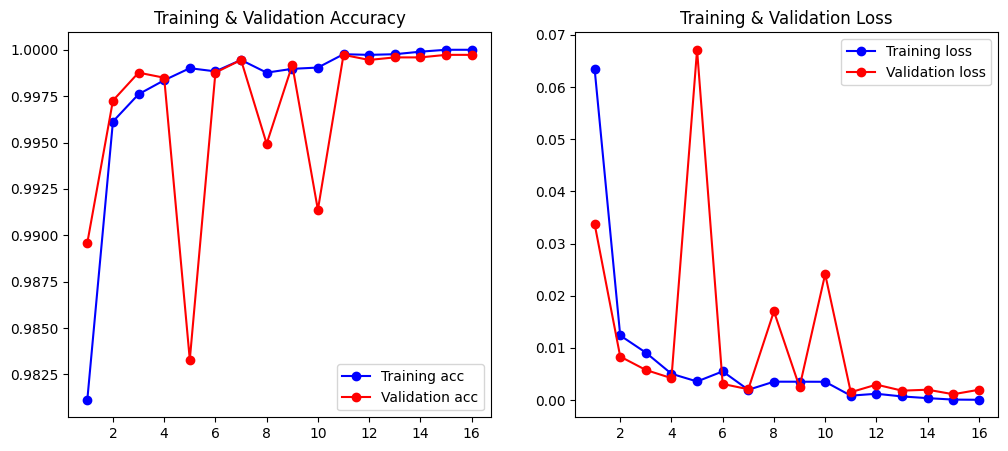

Training history saved to: models/model_20251206_143321\training_history.png


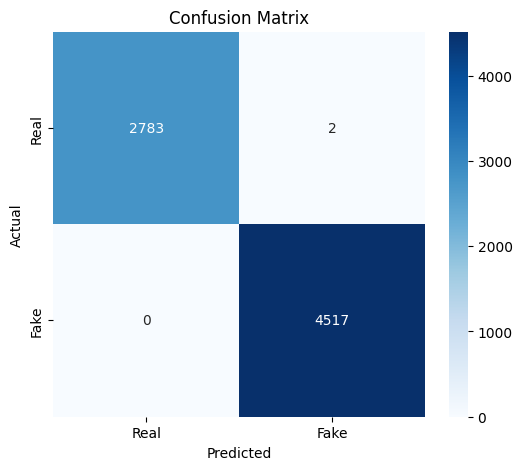

Confusion matrix saved to: models/model_20251206_143321\confusion_matrix.png


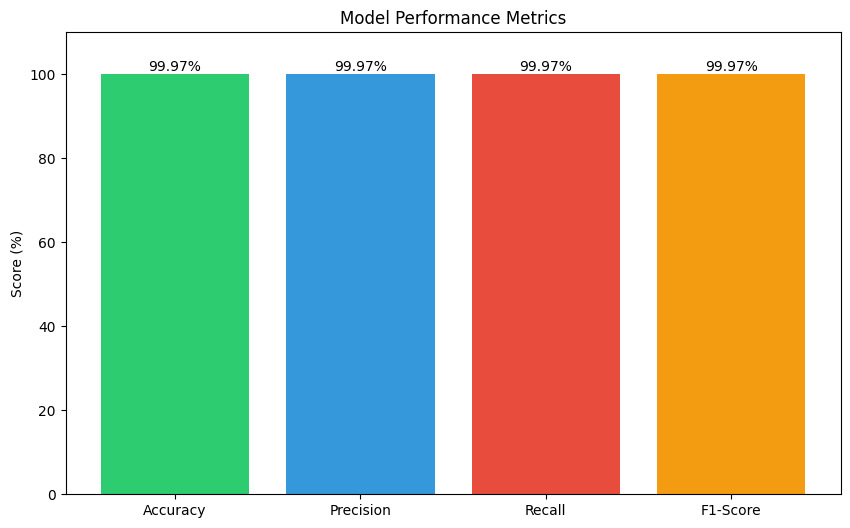

Performance metrics saved to: models/model_20251206_143321\performance_metrics.png

Classification Report:
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      2785
        Fake       1.00      1.00      1.00      4517

    accuracy                           1.00      7302
   macro avg       1.00      1.00      1.00      7302
weighted avg       1.00      1.00      1.00      7302

Classification report saved to: models/model_20251206_143321\classification_report.txt

TRAINING SESSION COMPLETE
Folder: models/model_20251206_143321/
  - model.keras
  - metrics.json
  - training_history.png
  - confusion_matrix.png
  - performance_metrics.png
  - classification_report.txt


In [9]:
# --- 6. Evaluation & Visualization ---

# Predictions
y_pred_prob = model.predict(val_gen)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

y_true = []
for i in range(len(val_gen)):
    _, batch_y = val_gen[i]
    y_true.extend(batch_y)
y_true = np.array(y_true)[:len(y_pred)]

# Calculate Metrics
cm = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

# Save Metrics to JSON
metrics_file = os.path.join(model_folder, 'metrics.json')
metrics_data = {
    'timestamp': timestamp,
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'confusion_matrix': cm.tolist(),
    'training_epochs': len(history.history['accuracy']),
    'final_val_accuracy': float(history.history['val_accuracy'][-1]),
    'final_val_loss': float(history.history['val_loss'][-1])
}

with open(metrics_file, 'w') as f:
    json.dump(metrics_data, f, indent=2)

print(f"\nMetrics saved to: {metrics_file}")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1-Score: {f1*100:.2f}%")

# Plot Training History
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo-', label='Training acc')
plt.plot(epochs_range, val_acc, 'ro-', label='Validation acc')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo-', label='Training loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation loss')
plt.title('Training & Validation Loss')
plt.legend()
history_plot = os.path.join(model_folder, 'training_history.png')
plt.savefig(history_plot)
plt.show()
print(f"Training history saved to: {history_plot}")

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
cm_plot = os.path.join(model_folder, 'confusion_matrix.png')
plt.savefig(cm_plot)
plt.show()
print(f"Confusion matrix saved to: {cm_plot}")

# Plot Metrics Bar Chart
metrics_dict = {'Accuracy': accuracy*100, 'Precision': precision*100, 'Recall': recall*100, 'F1-Score': f1*100}
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_dict.keys(), metrics_dict.values(), color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}%', ha='center', va='bottom')
plt.title('Model Performance Metrics')
plt.ylabel('Score (%)')
plt.ylim([0, 110])
metrics_plot = os.path.join(model_folder, 'performance_metrics.png')
plt.savefig(metrics_plot)
plt.show()
print(f"Performance metrics saved to: {metrics_plot}")

# Print Classification Report
print("\nClassification Report:")
report = classification_report(y_true, y_pred, target_names=['Real', 'Fake'])
print(report)

# Save Classification Report
report_file = os.path.join(model_folder, 'classification_report.txt')
with open(report_file, 'w') as f:
    f.write(report)
print(f"Classification report saved to: {report_file}")

print("\n" + "="*60)
print("TRAINING SESSION COMPLETE")
print("="*60)
print(f"Folder: {model_folder}/")
print(f"  - model.keras")
print(f"  - metrics.json")
print(f"  - training_history.png")
print(f"  - confusion_matrix.png")
print(f"  - performance_metrics.png")
print(f"  - classification_report.txt")
print("="*60)